In [1]:
import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from envs.trading_env import MyTradingEnv


INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1
LAMBDA_HOLD = 0.01
REWARD_SCALING=10.0
MAX_STEPS=None

TRAIN_VERSION = "v2"

df1 = pd.read_csv("../data/data_1h_2021.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/data_1h_2022.csv", index_col=0, parse_dates=True)
df3 = pd.read_csv("../data/data_1h_2023.csv", index_col=0, parse_dates=True)
df4 = pd.read_csv("../data/data_1h_2024.csv", index_col=0, parse_dates=True)

train_data = pd.concat([df1])

df_full = train_data.copy()


Q-Learning (Base)
------------------------------------------------------------

SARSA (Base)
------------------------------------------------------------
Файл не найден: ../training_data/checkpoints/exp_sarsa_v2/final_agent.pkl

SARSA-λ (Base)
------------------------------------------------------------
Файл не найден: ../training_data/checkpoints/exp_sarsa_lambda_v2/final_agent.pkl

Monte Carlo (Base)
------------------------------------------------------------
Файл не найден: ../training_data/checkpoints/exp_monte_carlo_v2/final_agent.pkl

Q-Learning (FT)
------------------------------------------------------------

SARSA (FT)
------------------------------------------------------------
Файл не найден: ../training_data/checkpoints/exp_sarsa_v2_finetune/final_agent.pkl

SARSA-λ (FT)
------------------------------------------------------------
Файл не найден: ../training_data/checkpoints/exp_sarsa_lambda_v2_finetune/final_agent.pkl

Monte Carlo (FT)
-----------------------------------

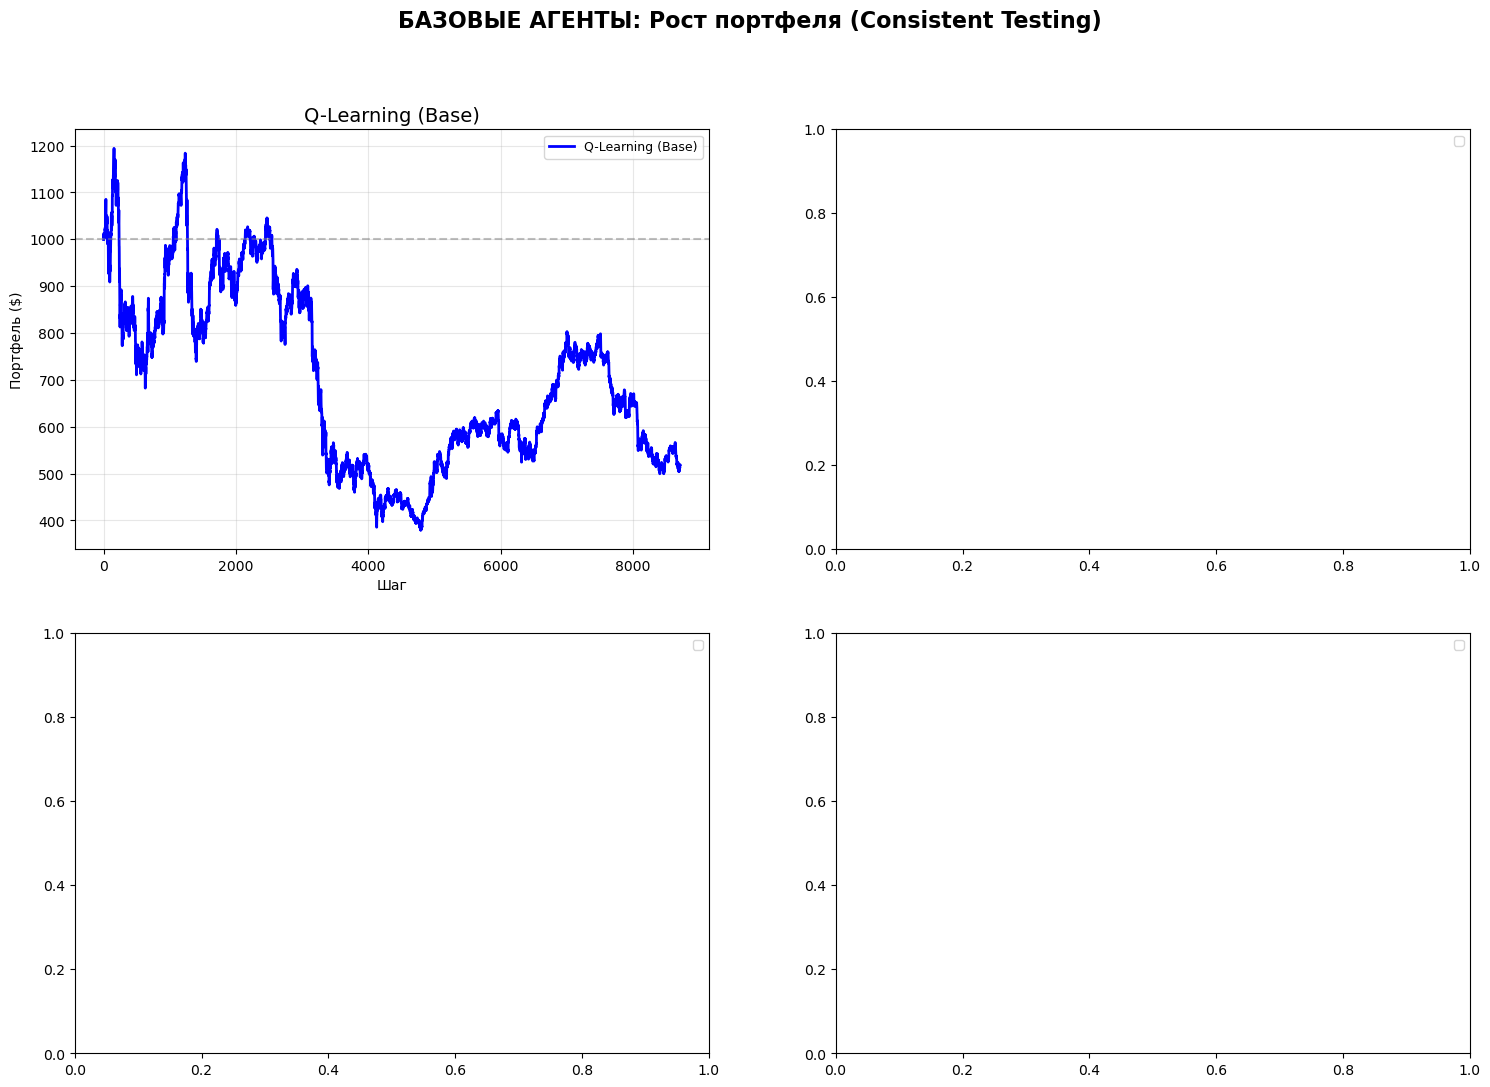

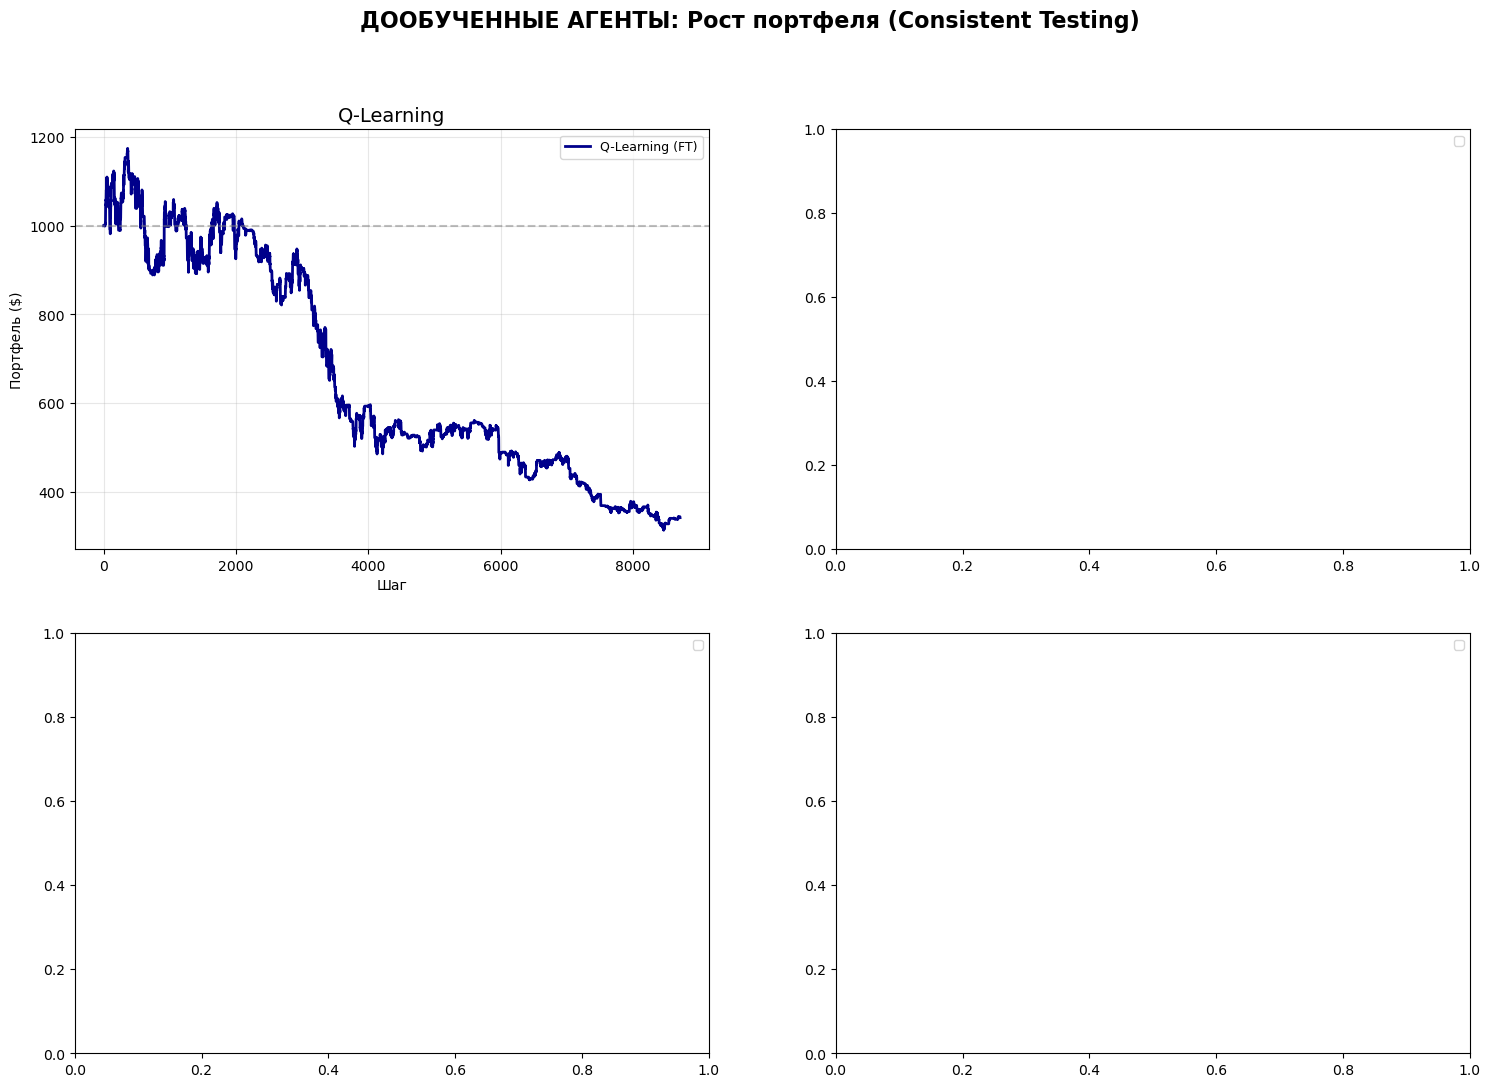

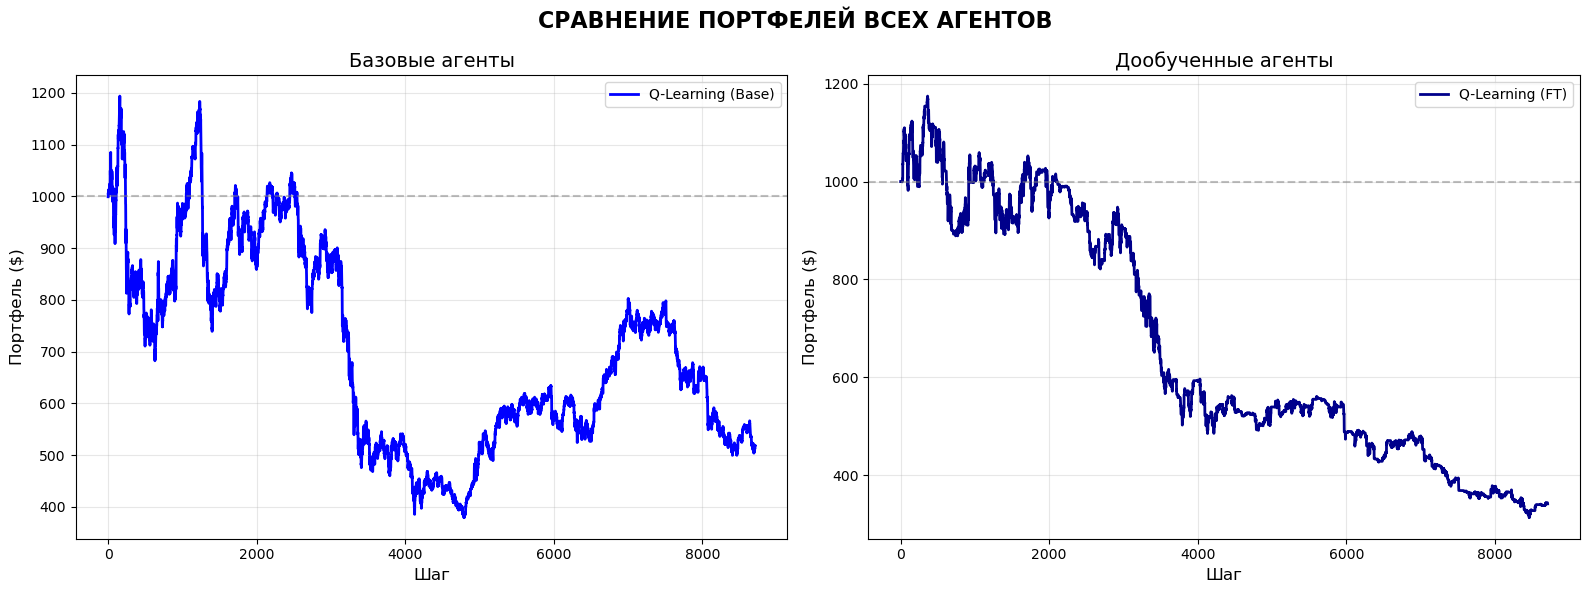


РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ ВСЕХ АГЕНТОВ
               Агент  Доходность %  Конечный баланс  Сделок  Win Rate %  \
0  Q-Learning (Base)        -48.11           518.95     768       82.94   
1    Q-Learning (FT)        -65.88           341.22    1155       49.26   

   Средний PnL  Max Drawdown сделок %  Max Drawdown портфеля %  Sharpe Ratio  \
0        -0.55                  12.97                    68.23         -0.07   
1        -0.50                  10.09                    73.36         -0.28   

   Ср. время удержания  Закрыто по просадке  Закрыто по времени  
0                10.34                  129                   0  
1                 3.14                   61                   0  

ТОП-3 ПО ДОХОДНОСТИ
               Агент  Доходность %  Конечный баланс  Sharpe Ratio  \
0  Q-Learning (Base)        -48.11           518.95         -0.07   
1    Q-Learning (FT)        -65.88           341.22         -0.28   

   Max Drawdown портфеля %  
0                    68.23  
1         

In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

class QLearningLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key, np.zeros(self.n_actions))
        return int(np.argmax(q))


class SARSALoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key, np.zeros(self.n_actions))
        return int(np.argmax(q))


class SARSALambdaLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.lambda_param = data["lambda_param"]
        self.replace_traces = data["replace_traces"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key, np.zeros(self.n_actions))
        return int(np.argmax(q))


class MonteCarloLoaded:
    def __init__(self, data):
        self.q_table = data.get("q_table", {})
        self.policy = data.get("policy", {})
        self.n_actions = data.get("n_actions", 3)

    def select_action(self, state, training=False):
        key = tuple(state)
        if key in self.policy:
            return int(np.argmax(self.policy[key]))
        if key in self.q_table:
            return int(np.argmax(self.q_table[key]))
        return np.random.randint(self.n_actions)


def load_agent(path):
    with open(path, "rb") as f:
        agent_instance = pickle.load(f)

    name = agent_instance.name.lower()

    loaded_data = {
        "q_table": agent_instance.q_table,
        "n_actions": agent_instance.n_actions,
        "name": agent_instance.name,
    }

    if "lambda" in name:
        loaded_data["lambda_param"] = getattr(agent_instance, 'lambda_param', None)
        loaded_data["replace_traces"] = getattr(agent_instance, 'replace_traces', None)
        return SARSALambdaLoaded(loaded_data)
        
    if "sarsa" in name:
        return SARSALoaded(loaded_data)
        
    if "q" in name:
        return QLearningLoaded(loaded_data)
        
    if "monte" in name:
        loaded_data["policy"] = getattr(agent_instance, 'policy', {}) 
        return MonteCarloLoaded(loaded_data)

    raise ValueError(f"Неизвестный агент: {agent_instance.name}")


class ConsistentAgentComparator:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        self.test_start = None
    
    def run_episode(self, env, agent, record_values=False):
        state, info = env.reset(seed=self.seed)
        done = False
        values = []
        
        if self.test_start is None:
            self.test_start = env.current_step
        
        done = False
        step = 0

        while not done:
            action = agent.select_action(state, training=False)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            done = terminated or truncated
            
            if record_values:
                values.append(info.get("portfolio_value", INITIAL_BALANCE))
            
            step += 1
            if step >= env.max_steps:
                break

        metrics = env.get_metrics()
        metrics["portfolio_value"] = info.get("portfolio_value", INITIAL_BALANCE)
        
        if record_values:
            return metrics, np.array(values)
        return metrics, None
    
    def run(self):
        agent_paths = {
            "Q-Learning (Base)": f"../training_data/checkpoints/exp_qlearning_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA (Base)": f"../training_data/checkpoints/exp_sarsa_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA-λ (Base)": f"../training_data/checkpoints/exp_sarsa_lambda_{TRAIN_VERSION}/final_agent.pkl",
            "Monte Carlo (Base)": f"../training_data/checkpoints/exp_monte_carlo_{TRAIN_VERSION}/final_agent.pkl",
            "Q-Learning (FT)": f"../training_data/checkpoints/exp_qlearning_{TRAIN_VERSION}_finetune/final_agent.pkl",
            "SARSA (FT)": f"../training_data/checkpoints/exp_sarsa_{TRAIN_VERSION}_finetune/final_agent.pkl",
            "SARSA-λ (FT)": f"../training_data/checkpoints/exp_sarsa_lambda_{TRAIN_VERSION}_finetune/final_agent.pkl",
            "Monte Carlo (FT)": f"../training_data/checkpoints/exp_monte_carlo_{TRAIN_VERSION}_finetune/final_agent.pkl",
        }

        df = df_full.copy()
        results = []
        portfolio_history = {}
        
        test_length = len(df) - WINDOW_SIZE - 1

        base_colors = ['blue', 'green', 'red', 'orange']
        ft_colors = ['darkblue', 'darkgreen', 'darkred', 'darkorange']
        
        all_agents = list(agent_paths.keys())
        
        fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
        fig1.suptitle('БАЗОВЫЕ АГЕНТЫ: Рост портфеля (Consistent Testing)', fontsize=16, fontweight='bold')
        
        fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))
        fig2.suptitle('ДООБУЧЕННЫЕ АГЕНТЫ: Рост портфеля (Consistent Testing)', fontsize=16, fontweight='bold')
        
        fig3, (ax3_base, ax3_ft) = plt.subplots(1, 2, figsize=(16, 6))
        fig3.suptitle('СРАВНЕНИЕ ПОРТФЕЛЕЙ ВСЕХ АГЕНТОВ', fontsize=16, fontweight='bold')

        base_results = []
        ft_results = []
        
        for i, (name, path) in enumerate(agent_paths.items()):
            print(f"\n{name}")
            print("-" * 60)

            if not Path(path).exists():
                print(f"Файл не найден: {path}")
                continue

            agent = load_agent(path)

            env = MyTradingEnv(
                df=df.copy(),
                initial_balance=INITIAL_BALANCE,
                window_size=WINDOW_SIZE,
                commission=COMMISSION,
                slippage=SLIPPAGE,
                max_holding_time=MAX_HOLDING_TIME,
                holding_threshold=HOLDING_THRESHOLD,
                max_drawdown_threshold=MAX_DRAWDOWN_THRESHOLD,
                lambda_drawdown=LAMBDA_DRAWDOWN,
                lambda_hold=LAMBDA_HOLD,
                reward_scaling=REWARD_SCALING,
                max_steps=test_length,  
            )
            metrics, values = self.run_episode(env, agent, record_values=True)
            
            if values is not None:
                if len(values) != test_length:
                    print(f"Внимание: агент {name} прошел {len(values)} шагов вместо {test_length}")
                    if len(values) < test_length:
                        values = np.pad(values, (0, test_length - len(values)), 
                                       mode='constant', constant_values=values[-1] if len(values) > 0 else INITIAL_BALANCE)
                    else:
                        values = values[:test_length]
            
            portfolio_history[name] = values

            if values is not None and len(values) > 0:
                peak = np.maximum.accumulate(values)
                dd = (peak - values) / (peak + 1e-8)
                max_dd = dd.max() if len(dd) else 0

                returns = np.diff(values) / values[:-1]
                sharpe = (
                    np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
                    if len(returns) > 1 else 0
                )
                
                final_value = values[-1] if len(values) > 0 else INITIAL_BALANCE
            else:
                max_dd = 0
                sharpe = 0
                final_value = INITIAL_BALANCE

            result_entry = {
                "Агент": name,
                "Доходность %": (final_value / INITIAL_BALANCE - 1) * 100,
                "Конечный баланс": final_value,
                "Сделок": metrics.get("total_trades", 0),
                "Win Rate %": metrics.get("win_rate", 0),
                "Средний PnL": metrics.get("avg_pnl", 0),
                "Max Drawdown сделок %": metrics.get("max_drawdown", 0) * 100,
                "Max Drawdown портфеля %": max_dd * 100,
                "Sharpe Ratio": sharpe,
                "Ср. время удержания": metrics.get("avg_holding_time", 0),
                "Закрыто по просадке": metrics.get("trades_closed_by_drawdown", 0),
                "Закрыто по времени": metrics.get("trades_closed_by_time", 0),
            }
            
            results.append(result_entry)
            
            if "(FT)" in name:
                ft_results.append(result_entry)
                agent_idx = list(agent_paths.keys()).index(name)
                base_idx = agent_idx - 4
                color_idx = base_idx % 4
                
                if color_idx < len(ft_colors):
                    color = ft_colors[color_idx]
                else:
                    color = ft_colors[color_idx % len(ft_colors)]
                    
                ax_idx = color_idx
                row = ax_idx // 2
                col = ax_idx % 2
                
                if values is not None and len(values) > 0:
                    axes2[row, col].plot(values, label=name, color=color, linewidth=2)
                    axes2[row, col].set_title(name.split(' (')[0], fontsize=14)
                    axes2[row, col].set_xlabel("Шаг", fontsize=10)
                    axes2[row, col].set_ylabel("Портфель ($)", fontsize=10)
                    axes2[row, col].grid(True, alpha=0.3)
                    axes2[row, col].axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', alpha=0.5)
                    
                ax3_ft.plot(values, label=name, color=color, linewidth=2)
            else:
                base_results.append(result_entry)
                color_idx = i % 4
                
                if color_idx < len(base_colors):
                    color = base_colors[color_idx]
                else:
                    color = base_colors[color_idx % len(base_colors)]
                    
                ax_idx = color_idx
                row = ax_idx // 2
                col = ax_idx % 2
                
                if values is not None and len(values) > 0:
                    axes1[row, col].plot(values, label=name, color=color, linewidth=2)
                    axes1[row, col].set_title(name, fontsize=14)
                    axes1[row, col].set_xlabel("Шаг", fontsize=10)
                    axes1[row, col].set_ylabel("Портфель ($)", fontsize=10)
                    axes1[row, col].grid(True, alpha=0.3)
                    axes1[row, col].axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', alpha=0.5)
                    
                ax3_base.plot(values, label=name, color=color, linewidth=2)

        for i in range(2):
            for j in range(2):
                axes1[i, j].legend(fontsize=9)
                axes2[i, j].legend(fontsize=9)
        
        ax3_base.set_title("Базовые агенты", fontsize=14)
        ax3_base.set_xlabel("Шаг", fontsize=12)
        ax3_base.set_ylabel("Портфель ($)", fontsize=12)
        ax3_base.grid(True, alpha=0.3)
        ax3_base.legend(fontsize=10)
        ax3_base.axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', alpha=0.5, label=f'Начальный баланс: ${INITIAL_BALANCE}')
        
        ax3_ft.set_title("Дообученные агенты", fontsize=14)
        ax3_ft.set_xlabel("Шаг", fontsize=12)
        ax3_ft.set_ylabel("Портфель ($)", fontsize=12)
        ax3_ft.grid(True, alpha=0.3)
        ax3_ft.legend(fontsize=10)
        ax3_ft.axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', alpha=0.5, label=f'Начальный баланс: ${INITIAL_BALANCE}')
        
        plt.tight_layout()
        plt.show()

        df_res = pd.DataFrame(results)
        print("\n" + "="*120)
        print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ ВСЕХ АГЕНТОВ")
        print("="*120)
        
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.float_format', '{:,.2f}'.format)
        
        print(df_res)
        
        print("\n" + "="*120)
        print("ТОП-3 ПО ДОХОДНОСТИ")
        print("="*120)
        
        top_return = df_res.sort_values("Доходность %", ascending=False).head(3)
        print(top_return[["Агент", "Доходность %", "Конечный баланс", "Sharpe Ratio", "Max Drawdown портфеля %"]])
        
        print("\n" + "="*120)
        print("ТОП-3 ПО SHARPE RATIO")
        print("="*120)
        
        top_sharpe = df_res.sort_values("Sharpe Ratio", ascending=False).head(3)
        print(top_sharpe[["Агент", "Sharpe Ratio", "Доходность %", "Конечный баланс", "Max Drawdown портфеля %"]])
        
        df_res.to_csv("consistent_comparison_results_all.csv", index=False)
        
        print("\n" + "="*120)
        print("СРАВНЕНИЕ BASE vs FINETUNE")
        print("="*120)
        
        comparison_data = []
        agent_types = ["Q-Learning", "SARSA", "SARSA-λ", "Monte Carlo"]
        
        for agent_type in agent_types:
            base_agent = f"{agent_type} (Base)"
            ft_agent = f"{agent_type} (FT)"
            
            base_data = df_res[df_res["Агент"] == base_agent]
            ft_data = df_res[df_res["Агент"] == ft_agent]
            
            if not base_data.empty and not ft_data.empty:
                base_row = base_data.iloc[0]
                ft_row = ft_data.iloc[0]
                
                return_diff = ft_row["Доходность %"] - base_row["Доходность %"]
                sharpe_diff = ft_row["Sharpe Ratio"] - base_row["Sharpe Ratio"]
                dd_diff = ft_row["Max Drawdown портфеля %"] - base_row["Max Drawdown портфеля %"]
                
                comparison_data.append({
                    "Тип агента": agent_type,
                    "Доходность Base": base_row["Доходность %"],
                    "Доходность FT": ft_row["Доходность %"],
                    "Δ Доходность": return_diff,
                    "Sharpe Base": base_row["Sharpe Ratio"],
                    "Sharpe FT": ft_row["Sharpe Ratio"],
                    "Δ Sharpe": sharpe_diff,
                    "MDD Base": base_row["Max Drawdown портфеля %"],
                    "MDD FT": ft_row["Max Drawdown портфеля %"],
                    "Δ MDD": dd_diff,
                })
        
        df_comparison = pd.DataFrame(comparison_data)
        print(df_comparison.round(2))
        df_comparison.to_csv("base_vs_finetune_comparison.csv", index=False)
        
        print(f"\nРезультаты сохранены в consistent_comparison_results_all.csv и base_vs_finetune_comparison.csv")

comparator = ConsistentAgentComparator(seed=42)
comparator.run()